Train using [progressive resizing](https://towardsdatascience.com/how-to-make-a-state-of-the-art-model-with-fastai-bd11e168b214): `As Jeremy Howard says in his book: start training using small images, and end training using large images. Spending most of the epochs training with small images, helps training complete much faster. Completing training using large images makes the final accuracy much higher.`

In [1]:
import fastai
from fastai.vision import *

In [2]:
from fastai.utils.show_install import *
show_install()



```text
=== Software === 
python        : 3.7.13
fastai        : 1.0.61
fastprogress  : 1.0.2
torch         : 1.10.0+cu111
nvidia driver : 460.32
torch cuda    : 11.1 / is available
torch cudnn   : 8005 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 15109MB | Tesla T4

=== Environment === 
platform      : Linux-5.4.144+-x86_64-with-Ubuntu-18.04-bionic
distro        : #1 SMP Tue Dec 7 09:58:10 PST 2021
conda env     : Unknown
python        : /usr/bin/python3
sys.path      : 
/content
/env/python
/usr/lib/python37.zip
/usr/lib/python3.7
/usr/lib/python3.7/lib-dynload
/usr/local/lib/python3.7/dist-packages
/usr/lib/python3/dist-packages
/usr/local/lib/python3.7/dist-packages/IPython/extensions
/root/.ipython
```

Please make sure to include opening/closing ``` when you paste into forums/github to make the reports appear formatted as code sections.

Optional package(s) to enhance the diagnostics can be installed with:
pip install distro
Once installed

In [3]:
!rm -r solar_seg/
!git clone https://github.com/tcapelle/solar_seg/

Cloning into 'solar_seg'...
remote: Enumerating objects: 6292, done.
remote: Total 6292 (delta 0), reused 0 (delta 0), pack-reused 6292
Receiving objects: 100% (6292/6292), 358.72 MiB | 41.77 MiB/s, done.
Resolving deltas: 100% (70/70), done.
Checking out files: 100% (7078/7078), done.


In [4]:
path = Path('solar_seg/')
path_lbl = path/'train_masks'
path_img = path/'train_images'

In [5]:
fnames = get_image_files(path_lbl)
fnames = [path_img/fname.name for fname in fnames]
len(fnames)

64

In [6]:
lbl_names = get_image_files(path_lbl)
len(lbl_names)

64

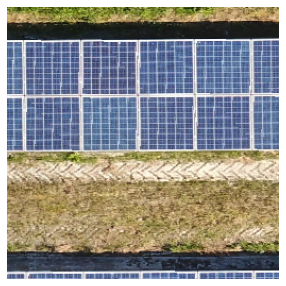

In [7]:
img_f = fnames[5]
img = open_image(img_f)
img.show(figsize=(5,5))

In [8]:
get_y_fn = lambda x: path_lbl/f'{x.stem}{x.suffix}'

In [9]:
get_y_fn(img_f)

PosixPath('solar_seg/train_masks/01286.png')

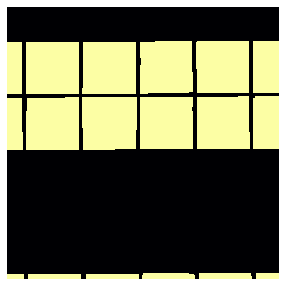

In [10]:
mask = open_mask(get_y_fn(img_f), div=True)
mask.show(figsize=(5,5), alpha=1, cmap = 'inferno')

In [11]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([256, 256]), tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1]]]))

In [12]:
size = src_size//2
bs=64

In [13]:
class MySegmentationLabelList(SegmentationLabelList):
  def open(self, fn): return open_mask(fn, div=True)

In [14]:
class MySegmentationItemList(ImageList): # rename ImageItemList to ImageList
    "`ItemList` suitable for segmentation tasks."
    _label_cls,_square_show_res = MySegmentationLabelList,False

In [15]:
MySegmentationItemList(fnames)

MySegmentationItemList (64 items)
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: .

In [16]:
def get_data(sz, bs):
  src = (MySegmentationItemList(fnames)
       .random_split_by_pct(.2)
       .label_from_func(get_y_fn, classes=['background','solar_module']))
  data = (src.transform(get_transforms(flip_vert=True), size=sz, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))
  return data

Train on images resized to 128

/usr/local/lib/python3.7/dist-packages/fastai/data_block.py:217: UserWarning: `random_split_by_pct` is deprecated, please use `split_by_rand_pct`.
  warn("`random_split_by_pct` is deprecated, please use `split_by_rand_pct`.")
/usr/local/lib/python3.7/dist-packages/fastai/vision/transform.py:247: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  return _solve_func(B,A)[0][:,0]


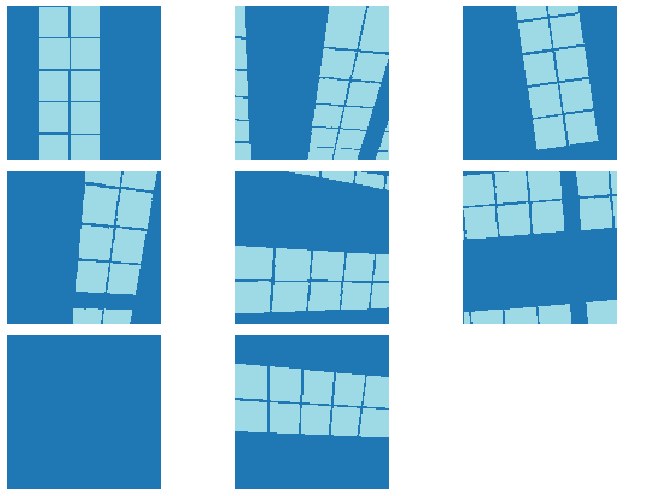

In [17]:
data = get_data(128, 8)
data.show_batch(4, figsize=(10,7), alpha=1)

In [18]:
metrics = partial(dice, iou=True)
wd = 1e-2

In [19]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


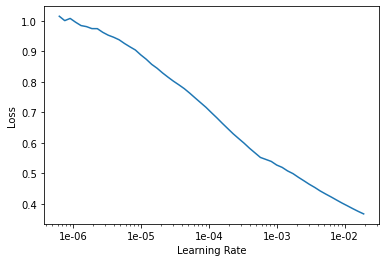

In [20]:
learn.lr_find(); learn.recorder.plot()

In [21]:
learn.fit_one_cycle(12, 5e-5)

epoch,train_loss,valid_loss,dice,time
0,0.922337,0.589145,0.014499,00:01
1,0.758355,0.474744,0.497845,00:01
2,0.639464,0.329226,0.703974,00:01
3,0.525346,0.187034,0.750200,00:01
4,0.437921,0.144147,0.798834,00:01
5,0.371619,0.120018,0.861144,00:01
6,0.321488,0.105912,0.875198,00:01
7,0.281208,0.096340,0.885548,00:01
8,0.250558,0.091039,0.891605,00:01
9,0.225117,0.088304,0.895142,00:01


In [22]:
learn.unfreeze()
learn.fit_one_cycle(12, slice(1e-5,1e-4))

epoch,train_loss,valid_loss,dice,time
0,0.093067,0.083671,0.898111,00:01
1,0.089949,0.075712,0.908463,00:01
2,0.085187,0.060427,0.929207,00:01
3,0.085661,0.078857,0.905496,00:01
4,0.083994,0.051929,0.939313,00:01
5,0.078965,0.046287,0.946266,00:01
6,0.074854,0.043367,0.950155,00:01
7,0.071108,0.045513,0.947702,00:01
8,0.068075,0.042231,0.948325,00:01
9,0.065417,0.042553,0.948430,00:01


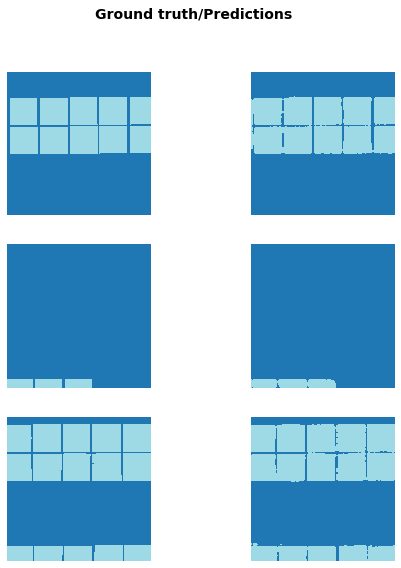

In [23]:
learn.show_results(rows=3, figsize=(8,9), alpha=1)

Train on full sized input 256 pixels

In [24]:
learn.data = get_data(256, 8)

/usr/local/lib/python3.7/dist-packages/fastai/data_block.py:217: UserWarning: `random_split_by_pct` is deprecated, please use `split_by_rand_pct`.
  warn("`random_split_by_pct` is deprecated, please use `split_by_rand_pct`.")


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


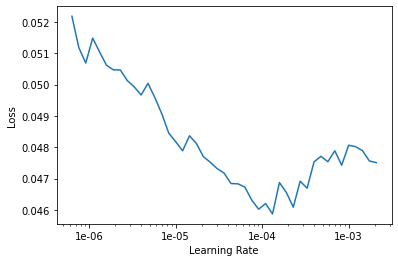

In [25]:
learn.freeze()
learn.lr_find(); learn.recorder.plot()

In [26]:
learn.freeze()
learn.fit_one_cycle(12, 1e-6)

epoch,train_loss,valid_loss,dice,time
0,0.049768,0.073240,0.874513,00:04
1,0.049613,0.075479,0.873200,00:03
2,0.048976,0.075393,0.873446,00:03
3,0.049039,0.074660,0.874216,00:03
4,0.048700,0.074107,0.874821,00:03
5,0.048480,0.072922,0.875824,00:03
6,0.047923,0.072206,0.876399,00:03
7,0.047515,0.071095,0.877338,00:03
8,0.047370,0.070936,0.877459,00:03
9,0.046956,0.070635,0.877688,00:03


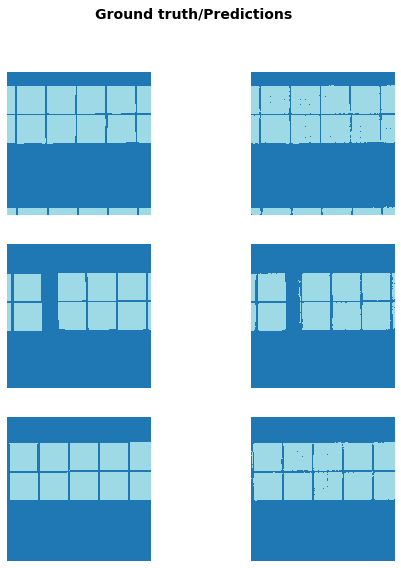

In [27]:
learn.show_results(rows=3, figsize=(8,9), alpha=1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


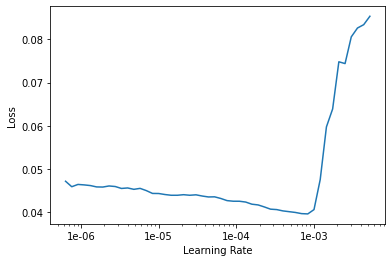

In [28]:
learn.unfreeze()
learn.lr_find(); learn.recorder.plot()

In [29]:
learn.fit_one_cycle(12, 1e-5)

epoch,train_loss,valid_loss,dice,time
0,0.046327,0.069439,0.878613,00:03
1,0.046253,0.067997,0.880384,00:03
2,0.044923,0.064761,0.882974,00:03
3,0.043433,0.063769,0.884823,00:03
4,0.042650,0.064236,0.884965,00:03
5,0.042049,0.062744,0.885560,00:03
6,0.041206,0.060736,0.886405,00:03
7,0.040556,0.062370,0.885987,00:03
8,0.040032,0.064002,0.885339,00:03
9,0.039518,0.063663,0.885359,00:03


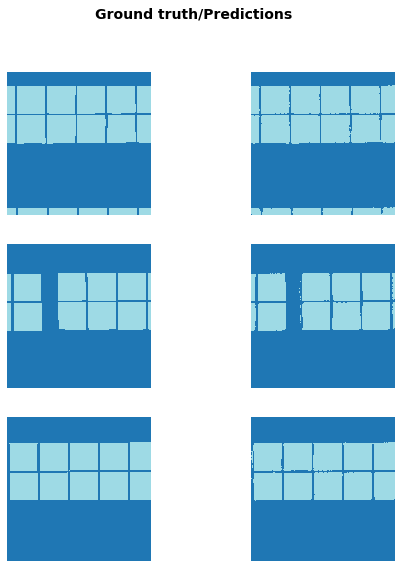

In [30]:
learn.show_results(rows=3, figsize=(8,9), alpha=1)